In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import json

In [25]:
%matplotlib inline

In [26]:
# Loading the data from 

data = mne.io.read_raw_eeglab('ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_eeg.set')
events = pd.read_csv('ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_acq-scoring_events.tsv', sep='\t')

with open("channels_map.json", 'r') as f:
    channels_map = json.load(f)
    f.close()

with open("channels_group.json", 'r') as f:
    channels_group = json.load(f)
    f.close()

total_time = data.n_times / data.info['sfreq']
print(f"EEG data have {data.n_times} time points, equal to {total_time/60} minutes --> can be divide into {total_time/30} epochs")
print(f"Events have {len(events)} lengths.")
data.set_channel_types(channels_map)

events = events.to_numpy()

# check if n_epoch is equal
assert round(total_time/30) == round(len(events)), "eeg data n_epochs not equal to label n_epochs"

Reading c:\Users\tiger\VScode project\eeg_sleep_stage\ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_eeg.fdt


EEG data have 5557600 time points, equal to 463.1333333333333 minutes --> can be divide into 926.2666666666667 epochs
Events have 926 lengths.


C:\Users\tiger\AppData\Local\Temp\ipykernel_24316\3243268303.py:17: RuntimeWarning: The unit for channel(s) DC1, DC2, DC3, DC4, DIF2, DIF3, DIF4, Event, OSAT has changed from V to NA.
  data.set_channel_types(channels_map)


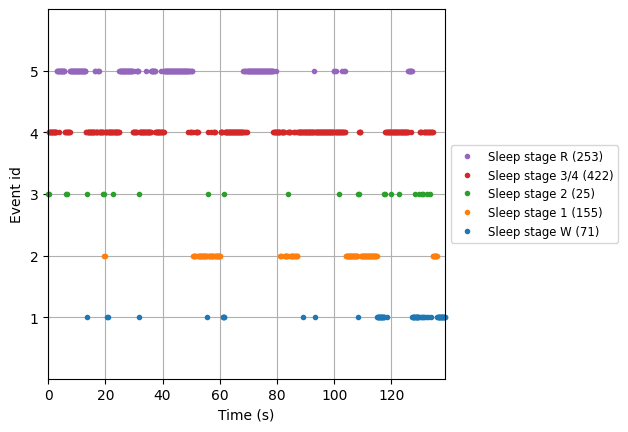

In [27]:
event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5
}

fig = mne.viz.plot_events(events, event_id=event_id, 
        sfreq = data.info['sfreq'], first_samp=events[0, 0])
plt.show()

In [28]:
# Selecting only scalp EEG channels
scalp_eeg = data.pick(channels_group['scalp_channels'])
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
scalp_eeg.set_montage(ten_twenty_montage)

<RawEEGLAB | sub-001_ses-001_task-sleep_eeg.fdt, 8 x 5557600 (27788.0 s), ~18 kB, data not loaded>

## Splitting the data into 30s epochs

using mne.Epochs

In [29]:
tmax = 30.0 - 1.0 / data.info['sfreq']  # tmax in included

epochs = mne.Epochs(raw=data, events=events, event_id=event_id,
                    baseline=None, preload=True,
                    tmin=0, tmax=tmax, proj=False)
print(epochs)

Not setting metadata
926 matching events found
No baseline correction applied
Loading data for 926 events and 6000 original time points ...
0 bad epochs dropped
<Epochs |  926 events (all good), 0 – 29.995 s, baseline off, ~339.1 MB, data loaded,
 'Sleep stage W': 71
 'Sleep stage 1': 155
 'Sleep stage 2': 25
 'Sleep stage 3/4': 422
 'Sleep stage R': 253>


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


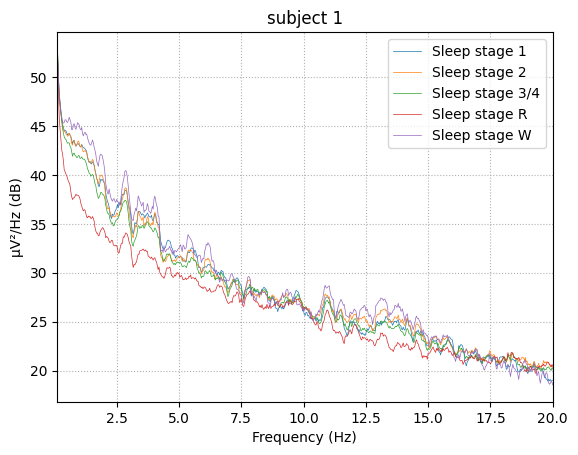

In [30]:
# visualize PSD by sleep stage.
fig, ax1 = plt.subplots(ncols=1)
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# iterate over the subjects
stages = sorted(event_id.keys())
for stage, color in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax1,
        show=False,
        average=True,
        spatial_colors=False,
        picks="data",
        exclude="bads",
    )
ax1.set(title='subject 1', xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax1.legend(ax1.lines[2::3], stages)

In [31]:
epochs.info

<Info | 8 non-empty values
 bads: []
 ch_names: F3, F4, C3, C4, O1, O2, A1, A2
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 200.0 Hz
>

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [14]:
from sklearn.model_selection import train_test_split

X = epochs.get_data()
y = epochs.events[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("train data shape:", X_train.shape)
print("train label shape:", y_train.shape)
print("test data shape:", X_test.shape)
print("test label shape:", y_test.shape)

train data shape: (740, 8, 1920)
train label shape: (740,)
test data shape: (186, 8, 1920)
test label shape: (186,)


In [19]:
from mne.time_frequency import psd_array_welch
from sklearn.preprocessing import normalize


FREQUENCY_BANDS = {
            'delta': [0.5, 4.5],
            'theta': [4.5, 8.5],
            'alpha': [8.5, 11.5],
            'sigma': [11.5, 15.5],
            'beta': [15.5, 30],
        }

def compute_psd_array(signal, sfreq=data.info['sfreq'], fmin=0.5, fmax=30):

    psd, freqs = psd_array_welch(signal, sfreq=sfreq, fmin=fmin, fmax=fmax)

    # splitting psd in to conventional frequency bands

    psd_norm = normalize(psd.mean(axis=1), axis=1)

    # x = []
    x_norm = []
    for fmin, fmax in FREQUENCY_BANDS.values():
        # psd_band = psd[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        psd_band_norm = psd_norm[:, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        # x.append(psd_band.reshape(len(psd), -1))
        x_norm.append(psd_band_norm.reshape(len(psd_norm), -1))

    return np.concatenate(x_norm, axis=1)

In [16]:
x_norm = compute_psd_array(X_train, sfreq=data.info['sfreq'])

Effective window size : 1.280 (s)


In [17]:
x_norm

array([[0.32804715, 0.11928703, 0.11503967, 0.05369725, 0.04265145],
       [0.41473876, 0.09503321, 0.04179433, 0.02043299, 0.00693367],
       [0.40128785, 0.09347446, 0.04108356, 0.01706949, 0.00741926],
       ...,
       [0.41235746, 0.12493684, 0.03389584, 0.01443287, 0.00522488],
       [0.36085887, 0.1545215 , 0.11157056, 0.07135627, 0.02749064],
       [0.31989563, 0.03666427, 0.02379387, 0.0228774 , 0.03597327]])

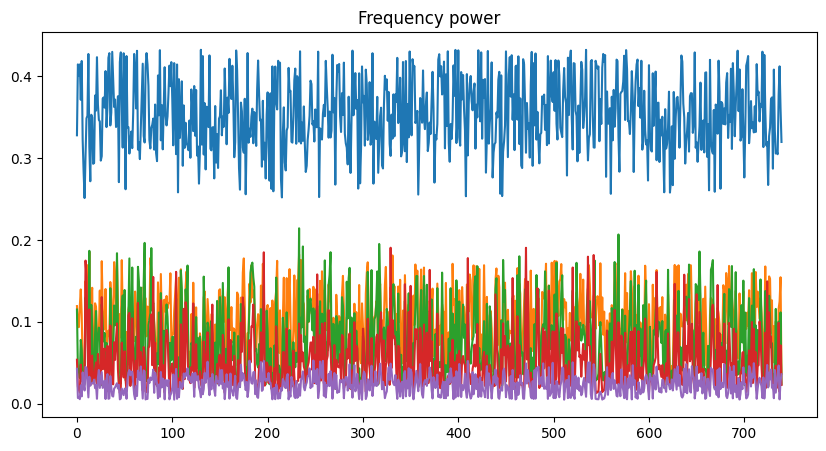

In [20]:
# x = list of each frequency band power
# x_norm = list of each frequency band power normalized
# 1st dimension = frequency band
# 2nd dimension = epoch
# visualize power band of each epoch

plt.figure(figsize=(10, 5))
plt.title(f"Frequency power")

for i, band in enumerate(FREQUENCY_BANDS.keys()):
    plt.plot(x_norm[:, i])

plt.show()

In [35]:
# creating sklearn pipeline

pipe = make_pipeline(
    FunctionTransformer(compute_psd_array, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

NameError: name 'num_loops' is not defined

In [41]:
from sklearn.model_selection import StratifiedKFold

X = epochs.get_data()
y = epochs.events[:, -1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

acc_sum = []
conf_matrix_sum = None

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):

    print(f"--Fold {i+1}:", train_idx.shape, test_idx.shape)

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # train RF model
    pipe.fit(X_train, y_train)

    # evaluate model
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix =  confusion_matrix(y_test, y_pred)

    acc_sum.append(acc)

    if conf_matrix_sum is None:
        conf_matrix_sum = conf_matrix
    else:
        conf_matrix_sum += conf_matrix
    
    print(f"Accuracy: {acc}")
    print(f"Confusion matrix:\n{conf_matrix}")


--Fold 1: (740,) (186,)
Effective window size : 1.280 (s)


Effective window size : 1.280 (s)
Accuracy: 0.6075268817204301
Confusion matrix:
[[ 6  3  0  6  0]
 [ 2 15  1 12  1]
 [ 0  0  0  5  0]
 [ 8  3  0 61 13]
 [ 0  3  0 16 31]]
--Fold 2: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6486486486486487
Confusion matrix:
[[ 3  2  1  8  0]
 [ 0 11  0 17  3]
 [ 2  0  0  3  0]
 [ 4  8  0 64  9]
 [ 0  0  0  8 42]]
--Fold 3: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6378378378378379
Confusion matrix:
[[ 6  2  0  6  0]
 [ 2 17  0 12  0]
 [ 0  0  0  4  1]
 [ 7  5  1 62  9]
 [ 0  2  0 16 33]]
--Fold 4: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6702702702702703
Confusion matrix:
[[ 4  2  0  8  0]
 [ 0 15  0 16  0]
 [ 0  1  0  2  2]
 [ 4  4  2 68  6]
 [ 0  1  0 13 37]]
--Fold 5: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6378378378378379
Confusion matrix:

In [43]:
np.mean(acc_sum)

0.640424295263005

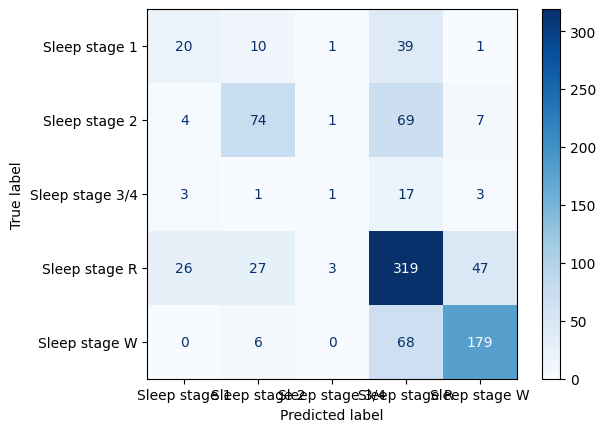

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(conf_matrix_sum, display_labels=stages)
disp.plot(cmap='Blues')
plt.show()

## Downsampling to 64 Hz for computational purposes

In [45]:
# Our data have 200 hz sampling rate, we might downsample it to 64, 100 Hz for computational sake

epochs = epochs.resample(64, npad='auto')

Sampling frequency of the instance is already 64.0, returning unmodified.


In [46]:
from sklearn.model_selection import StratifiedKFold

X = epochs.get_data()
y = epochs.events[:, -1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

acc_sum = []
conf_matrix_sum = None

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):

    print(f"--Fold {i+1}:", train_idx.shape, test_idx.shape)

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # train RF model
    pipe.fit(X_train, y_train)

    # evaluate model
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix =  confusion_matrix(y_test, y_pred)

    acc_sum.append(acc)

    if conf_matrix_sum is None:
        conf_matrix_sum = conf_matrix
    else:
        conf_matrix_sum += conf_matrix
    
    print(f"Accuracy: {acc}")
    print(f"Confusion matrix:\n{conf_matrix}")


--Fold 1: (740,) (186,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.5967741935483871
Confusion matrix:
[[ 2  1  1 11  0]
 [ 0 17  0 13  1]
 [ 1  0  0  3  1]
 [ 9  7  0 56 13]
 [ 1  1  0 12 36]]
--Fold 2: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6432432432432432
Confusion matrix:
[[ 4  1  0  9  0]
 [ 2 14  1 12  2]
 [ 0  1  1  3  0]
 [ 7  6  1 65  6]
 [ 1  1  0 13 35]]
--Fold 3: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6378378378378379
Confusion matrix:
[[ 4  5  0  5  0]
 [ 1 18  0 11  1]
 [ 3  1  0  1  0]
 [ 3 14  1 54 12]
 [ 0  0  0  9 42]]
--Fold 4: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size : 1.280 (s)
Accuracy: 0.6810810810810811
Confusion matrix:
[[ 4  1  0  9  0]
 [ 0 17  1 13  0]
 [ 1  1  0  2  1]
 [ 2  2  1 74  5]
 [ 0  1  0 19 31]]
--Fold 5: (741,) (185,)
Effective window size : 1.280 (s)
Effective window size 

In [47]:
np.mean(acc_sum)

0.6296251089799478

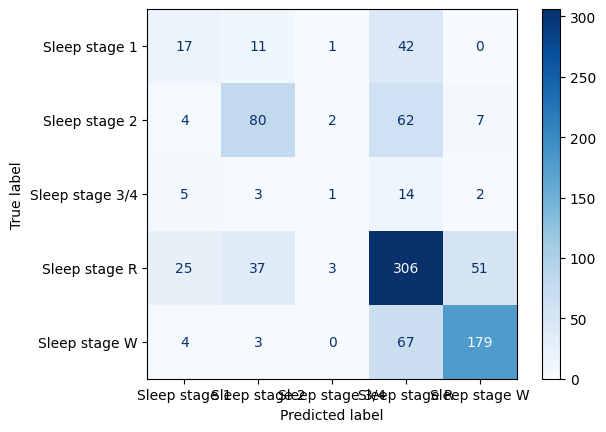

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(conf_matrix_sum, display_labels=stages)
disp.plot(cmap='Blues')
plt.show()

## Not bin into frequency band

In [52]:
psd, freqs = psd_array_welch(X, sfreq=data.info['sfreq'], fmin=0.5, fmax=30)



Effective window size : 1.280 (s)


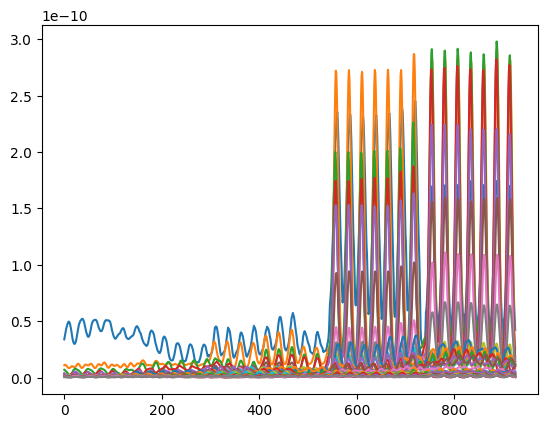

In [64]:
plt.plot(psd.mean(axis=1))

In [60]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

for i in range(psd.shape[1]): # iterate over channels

    print(f"--Channel {i}")
    
    X = psd[:, i, :]
    y = epochs.events[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix =  confusion_matrix(y_test, y_pred)

    print(f"Accuracy of channel {i}: {acc}")
    print(f"Confusion_matrix of channel {i}:\n{conf_matrix}")

--Channel 0
Accuracy of channel 0: 0.44086021505376344
Confusion_matrix of channel 0:
[[ 0  0  0 14  0]
 [ 0  0  0 28  0]
 [ 0  0  0  2  0]
 [ 0  0  0 82  0]
 [ 0  0  0 60  0]]
--Channel 1
Accuracy of channel 1: 0.44086021505376344
Confusion_matrix of channel 1:
[[ 0  0  0 14  0]
 [ 0  0  0 28  0]
 [ 0  0  0  2  0]
 [ 0  0  0 82  0]
 [ 0  0  0 60  0]]
--Channel 2
Accuracy of channel 2: 0.44086021505376344
Confusion_matrix of channel 2:
[[ 0  0  0 14  0]
 [ 0  0  0 28  0]
 [ 0  0  0  2  0]
 [ 0  0  0 82  0]
 [ 0  0  0 60  0]]
--Channel 3
Accuracy of channel 3: 0.44086021505376344
Confusion_matrix of channel 3:
[[ 0  0  0 14  0]
 [ 0  0  0 28  0]
 [ 0  0  0  2  0]
 [ 0  0  0 82  0]
 [ 0  0  0 60  0]]
--Channel 4
Accuracy of channel 4: 0.44086021505376344
Confusion_matrix of channel 4:
[[ 0  0  0 14  0]
 [ 0  0  0 28  0]
 [ 0  0  0  2  0]
 [ 0  0  0 82  0]
 [ 0  0  0 60  0]]
--Channel 5
Accuracy of channel 5: 0.44086021505376344
Confusion_matrix of channel 5:
[[ 0  0  0 14  0]
 [ 0  0  0 